[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guilbera/colorizing/blob/main/notebooks/pytorch_implementation/put_together_pix2pix.ipynb)

In [ ]:
import os, re, torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torchvision.utils import save_image
from PIL import Image
from torchvision import transforms
from skimage.color import rgb2gray
from shutil import copytree

In [ ]:
if 'google.colab' in str(get_ipython()):

  #mount google drive
  from google.colab import drive
  drive.mount('/content/drive')

  #copy the relevant notebooks
  !git clone https://github.com/guilbera/colorizing.git
  copy(os.path.join('/content/colorizing/notebooks/utilities/pix.ipynb'), '/content/drive/MyDrive/Colab Notebooks/')
  for nbs in os.listdir('/content/colorizing/notebooks/pytorch_implementation/'):
    copy(os.path.join('/content/colorizing/notebooks/pytorch_implementation/', nbs), '/content/drive/MyDrive/Colab Notebooks/')

  #kora library enables using notebooks like modules
  !pip install kora -q
  from kora import drive
  drive.link_nbs()

  #copy the dataset to google drive
  if not os.path.exists('/content/drive/MyDrive/datasets/'):
    !mkdir '/content/drive/MyDrive/datasets/'
    %cd '/content/drive/My Drive/datasets/'
    !gdown --id '1hNXR_qPwNKS-z3xNQJ4fWlEWe-zES_nX'
    %cd '/content/'

     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
Mounted at /content/drive


In [ ]:
from pix import copy_dataset, rgb_to_lab, lab_to_rgb
from pix_pytorch import make_dataloaders
from pix2pix_model import Generator, Discriminator, init_weights, DiscriminatorLoss

importing Jupyter notebook from /nbs/pix.ipynb


In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

### Parameters

In [ ]:
BATCH_SIZE = 64
IM_SIZE = 256
CROP_SIZE = 256
nb_of_output_channels = 3 #for RGB, 3 - for Lab, 2

dir = '/content/drive/MyDrive/datasets/dataset_1.zip'
model_path = '/content/drive/My Drive/capstone_results/pix2pix_RGB'
log_path = os.path.join(model_path, 'logs')
checkpoint_dir = os.path.join(model_path, 'chkpt_'+str(BATCH_SIZE))
img_dir = os.path.join(model_path, 'images_'+str(BATCH_SIZE))
img_train = os.path.join(img_dir, 'from_training')
img_test = os.path.join(img_dir, 'from_test')

if not os.path.exists(model_path):
   os.mkdir(model_path)
if not os.path.exists(log_path):
   os.mkdir(log_path)
if not os.path.exists(checkpoint_dir):
   os.mkdir(checkpoint_dir)
if not os.path.exists(img_dir):
   os.mkdir(img_dir)
if not os.path.exists(img_train):
   os.mkdir(img_train)
if not os.path.exists(img_test):
   os.mkdir(img_test)

### Prepare images

In [ ]:
def lab_to_rgb_pytorch(L, ab):
  """lab_to_rgb takes a numpy stack [B, H, W ,C] as input and
     return a numpy stack in the same format"""
  L = L.permute(0, 2, 3, 1).cpu().numpy()
  ab = ab.permute(0, 2, 3, 1).detach().cpu().numpy()
  return torch.from_numpy(lab_to_rgb(L, ab)).permute(0, 3, 1, 2)

In [ ]:
copy_dataset(dir)

In [ ]:
generator = make_dataloaders(batch_size=BATCH_SIZE, im_size=IM_SIZE, crop_size=CROP_SIZE, split='Train', paths='/content/dataset/dataset_1/Train', n_workers=2)
track_train = make_dataloaders(batch_size=5, im_size=IM_SIZE, crop_size=CROP_SIZE, split='Test', paths='/content/dataset/dataset_1/Train', n_workers=2, shuffle=False)
track_test = make_dataloaders(batch_size=5, im_size=IM_SIZE, crop_size=CROP_SIZE, split='Test', paths='/content/drive/My Drive/display/', n_workers=2, shuffle=False)

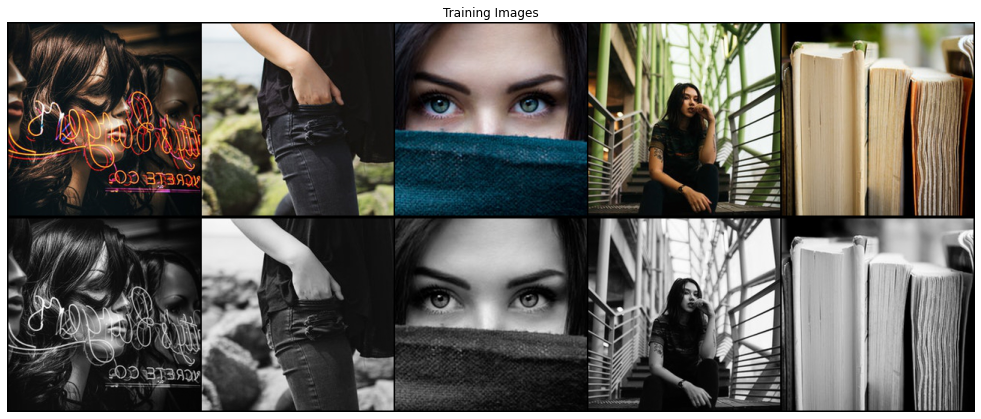

In [ ]:
track_train_batch = next(iter(track_train))
color = lab_to_rgb_pytorch(track_train_batch[0]['L'], track_train_batch[0]['ab'])
color_grid = vutils.make_grid(color.to(device), padding=2, normalize=True, nrow=5).cpu()
bw_grid = vutils.make_grid(track_train_batch[0]['L'].to(device), padding=2, normalize=True, nrow=5).cpu()
fig, ax = plt.subplots(2, 1, figsize=(16, 6))
plt.tight_layout()
ax[0].set_title('Training Images')
ax[0].imshow(np.transpose(color_grid,(1,2,0)))
ax[0].set_axis_off()
ax[1].imshow(np.transpose(bw_grid,(1,2,0)))
ax[1].set_axis_off()
fig.subplots_adjust(hspace=0.)
save_image(color_grid, os.path.join(img_train, 'train_color.png'))
save_image(bw_grid, os.path.join(img_train, 'train_bw.png'))

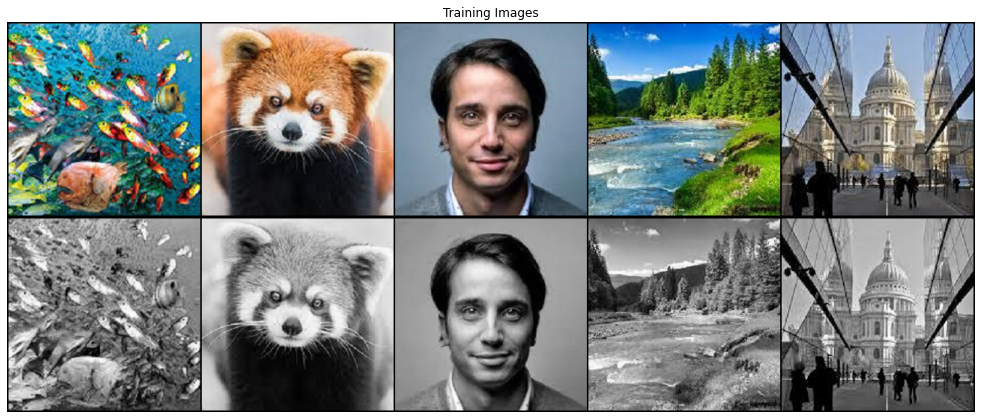

In [ ]:
track_test_batch = next(iter(track_test))
color = lab_to_rgb_pytorch(track_test_batch[0]['L'], track_test_batch[0]['ab'])
color_grid = vutils.make_grid(color.to(device), padding=2, normalize=True, nrow=5).cpu()
bw_grid = vutils.make_grid(track_test_batch[0]['L'].to(device), padding=2, normalize=True, nrow=5).cpu()
fig, ax = plt.subplots(2, 1, figsize=(16, 6))
plt.tight_layout()
ax[0].set_title('Training Images')
ax[0].imshow(np.transpose(color_grid,(1,2,0)))
ax[0].set_axis_off()
ax[1].imshow(np.transpose(bw_grid,(1,2,0)))
ax[1].set_axis_off()
fig.subplots_adjust(hspace=0.)
save_image(color_grid, os.path.join(img_test, 'train_color.png'))
save_image(bw_grid, os.path.join(img_test, 'train_bw.png'))

### Set up the model

In [ ]:
net_G = Generator(nb_of_output_channels).to(device)
net_D = Discriminator().to(device)

In [ ]:
opt_G = optim.Adam(net_G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(net_D.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
# load the latest model if it finds checkpoint files in the checkpoint directory
if os.listdir(checkpoint_dir):
    nums = [int(re.split('\-|\.', f)[1]) for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    cpkt = torch.load(os.path.join(checkpoint_dir, 'cp-'+str(max(nums))+'.pth'), map_location=device)
    net_G.load_state_dict(cpkt['G_state_dict'])
    net_D.load_state_dict(cpkt['D_state_dict'])
    opt_G.load_state_dict(cpkt['optimizerG_state_dict'])
    opt_D.load_state_dict(cpkt['optimizerD_state_dict'])
    epoch = cpkt['epoch']
    loss_G = cpkt['loss_G']
    loss_D = cpkt['loss_D']
    net_G.train()
    net_D.train()
    initial_epoch = epoch+1
# otherwise it initialise the weights
else:
    net_G = net_G.apply(init_weights).train()
    net_D = net_D.apply(init_weights).train()
    initial_epoch = 0
print(initial_epoch)

21


### Training

In [ ]:
GANcriterion = DiscriminatorLoss(device)
criterion = nn.L1Loss()
lambda1 = 100.
writer = SummaryWriter(log_dir=log_path)

In [ ]:
for epoch in range(initial_epoch, 51):
    running_loss_D = 0.0
    running_loss_G = 0.0
    for i, data in tqdm(enumerate(generator)):
        
          L, ab = data[0]['L'].to(device), data[0]['ab'].to(device)
          fake_color = net_G(L)
          real_image = torch.cat([L, ab], dim=1)
          if nb_of_output_channels == 2:
            fake_image = torch.cat([L, fake_color], dim=1)
          elif nb_of_output_channels == 3:
            fake_image = fake_color
            rgb = data[1].to(device)

          #train discriminator
          opt_D.zero_grad()
          #train on real images
          real_preds = net_D(real_image)
          loss_D_real = GANcriterion(real_preds, True)      
          #train on fake images
          fake_preds = net_D(fake_image.detach())
          loss_D_fake = GANcriterion(fake_preds, False)
          #total loss for D
          loss_D = (loss_D_fake + loss_D_real) * 0.5
          loss_D.backward()
          opt_D.step()

          #train generator
          opt_G.zero_grad()
          #train G using GAN criterion
          fake_preds = net_D(fake_image)
          loss_G_GAN = GANcriterion(fake_preds, True)
          #cycle GAN _ same training as for autoencoder times hyperparameter
          if nb_of_output_channels == 2:
            loss_G_L1 = criterion(fake_color, ab) * lambda1
          elif nb_of_output_channels == 3:
            loss_G_L1 = criterion(fake_color, rgb) * lambda1
          #total loss for G
          loss_G = loss_G_GAN + loss_G_L1
          loss_G.backward()
          opt_G.step()

          running_loss_D += loss_D.item()
          running_loss_G += loss_G.item()

    running_loss_D = running_loss_D/(i+1)
    running_loss_G = running_loss_G/(i+1)
    writer.add_scalar('loss_D', running_loss_D, epoch)
    writer.add_scalar('loss_G', running_loss_G, epoch)

    #print statistics [epoch, number of steps, loss_G, loss_D]
    print('[%d, %5d] loss: %.3f %.3f' %
                (epoch, i + 1, running_loss_G, running_loss_D))
    
    checkpoint_path = os.path.join(checkpoint_dir, 'cp-{}.pth'.format(epoch))
    torch.save({'epoch': epoch,
                'G_state_dict': net_G.state_dict(),
                'D_state_dict': net_D.state_dict(),
                'optimizerG_state_dict': opt_G.state_dict(),
                'optimizerD_state_dict': opt_D.state_dict(),
                'loss_G': loss_G,
                'loss_D': loss_D
                }, checkpoint_path)
    
    if nb_of_output_channels == 2:
        color_train = lab_to_rgb_pytorch(track_train_batch[0]['L'].to(device), net_G(track_train_batch[0]['L'].to(device)))
        color_test = lab_to_rgb_pytorch(track_test_batch[0]['L'].to(device), net_G(track_test_batch[0]['L'].to(device)))
    elif nb_of_output_channels == 3:
        color_train = net_G(track_train_batch[0]['L'].to(device))*255
        color_test = net_G(track_test_batch[0]['L'].to(device))*255

    color_train_grid = vutils.make_grid(color_train.to(device), padding=2, normalize=True, nrow=5).cpu() 
    color_test_grid = vutils.make_grid(color_test.to(device), padding=2, normalize=True, nrow=5).cpu()

    writer.add_image('train_images', color_train_grid, epoch)
    writer.add_image('test_images', color_test_grid, epoch)

    train_path = os.path.join(img_train, 'img-{}.png'.format(epoch))
    test_path = os.path.join(img_test, 'img-{}.png'.format(epoch))
    save_image(color_train_grid, train_path)
    save_image(color_test_grid, test_path)

    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(color_test_grid,(1,2,0)))
    
writer.close()

146it [05:23,  2.22s/it]


[21,   146] loss: 9.036 0.000


146it [05:24,  2.22s/it]


[22,   146] loss: 8.815 0.000


146it [05:24,  2.22s/it]


[23,   146] loss: 8.767 0.000


146it [05:24,  2.22s/it]


[24,   146] loss: 8.634 0.000


146it [05:24,  2.22s/it]


[25,   146] loss: 8.668 0.000


146it [05:24,  2.22s/it]


[26,   146] loss: 8.250 0.000


146it [05:24,  2.22s/it]


[27,   146] loss: 8.241 0.000


146it [05:24,  2.22s/it]


[28,   146] loss: 8.089 0.000


146it [05:24,  2.22s/it]


[29,   146] loss: 8.063 0.000


146it [05:24,  2.22s/it]


[30,   146] loss: 7.959 0.000


146it [05:24,  2.22s/it]


[31,   146] loss: 8.043 0.000


146it [05:24,  2.22s/it]


[32,   146] loss: 7.882 0.000


146it [05:24,  2.22s/it]


[33,   146] loss: 7.788 0.000


146it [05:24,  2.22s/it]


[34,   146] loss: 7.726 0.000


146it [05:24,  2.22s/it]


[35,   146] loss: 7.591 0.000


146it [05:24,  2.22s/it]


[36,   146] loss: 7.712 0.000


146it [05:24,  2.22s/it]


[37,   146] loss: 7.565 0.000


146it [05:24,  2.22s/it]


[38,   146] loss: 7.434 0.000


146it [05:24,  2.23s/it]


[39,   146] loss: 7.496 0.000


146it [05:24,  2.22s/it]


[40,   146] loss: 7.325 0.000


146it [05:24,  2.22s/it]


[41,   146] loss: 7.302 0.000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
146it [05:24,  2.22s/it]


[42,   146] loss: 7.165 0.000


146it [05:24,  2.22s/it]


[43,   146] loss: 7.289 0.000


146it [05:24,  2.22s/it]


[44,   146] loss: 7.477 0.000


146it [05:24,  2.22s/it]


[45,   146] loss: 7.220 0.000


146it [05:24,  2.22s/it]


[46,   146] loss: 7.032 0.000


146it [05:24,  2.22s/it]


[47,   146] loss: 7.098 0.000


9it [00:22,  2.36s/it]

In [ ]:
%load_ext tensorboard

In [ ]:
copytree(log_path, '/content/logs')

In [ ]:
%tensorboard --logdir logs